In [16]:
import os
import tempfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
dataset_path = 'dataset'
image_size = (224, 224)
batch_size = 32

if os.path.exists(dataset_path):
    print(f"Dataset bulundu: {dataset_path}")
else:
    print("Dataset bulunamadı")

Dataset bulundu: dataset


In [9]:
# data loading

datagen = ImageDataGenerator(
    rescale = 1./255, #normalization 
    validation_split = 0.3 # %70 train %30 validation
)

# train dataset settings
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

# validation dataset settings
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 36965 images belonging to 38 classes.
Found 15820 images belonging to 38 classes.


In [14]:
# hyperparameter tuning - bayesian optimization 
def model_builder(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = Dense(units=hp_units, activation='relu')(x)
    
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.05)
    x = Dropout(rate=hp_dropout)(x)
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=AdamW(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) 
    
    return model

temp_dir = tempfile.mkdtemp()

tuner = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_accuracy',
    max_trials = 5,
    overwrite = True,
    directory = temp_dir,        
    project_name = 'plant_disease_tuning'
)

tuner.search(
    train_generator,
    epochs = 5,
    validation_data = validation_generator, 
    verbose = 1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"Best Unit: {best_hps.get('units')}")
print(f"Best Dropout: {best_hps.get('dropout')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

try:
    shutil.rmtree(temp_dir)
    print("temp klasörü silindi")
except Exception as e:
    print(f"temp klasörü silinirken hata oluştu: {e}")

Trial 5 Complete [00h 24m 24s]
val_accuracy: 0.9504424929618835

Best val_accuracy So Far: 0.9572060704231262
Total elapsed time: 02h 17m 09s
Best Unit: 352
Best Dropout: 0.30000000000000004
Best Learning Rate: 0.0004996902435350934
temp klasörü silindi


In [18]:
# train model 
model = tuner.hypermodel.build(best_hps)

model.compile(
    optimizer=AdamW(learning_rate=best_hps.get('learning_rate')),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath='plant_disease.h5',
    monitor='val_accuracy',
    mode = 'min',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    callbacks=[checkpoint]
)

print("training tamamlandi ve min loss ile model kaydedildi")


Epoch 1/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7466 - loss: 0.9496
Epoch 1: val_accuracy improved from None to 0.92263, saving model to plant_disease.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 260s 223ms/step - accuracy: 0.8478 - loss: 0.5278 - val_accuracy: 0.9226 - val_loss: 0.2400
Epoch 2/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9295 - loss: 0.2146
Epoch 2: val_accuracy did not improve from 0.92263
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 272s 235ms/step - accuracy: 0.9307 - loss: 0.2110 - val_accuracy: 0.9480 - val_loss: 0.1616
Epoch 3/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9482 - loss: 0.1594
Epoch 3: val_accuracy did not improve from 0.92263
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 285s 247ms/step - accuracy: 0.9489 - loss: 0.1539 - val_accuracy: 0.9494 - val_loss: 0.1509
Epoch 4/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9593 - loss: 0.1249
Epoch 4: val_accuracy did not improve from 0.92263
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 270s 234ms/step - accuracy: 0.9570 - loss: 0.1301 - val_accuracy: 0.9535 - val_loss: 0.1375
Epoch 5/20
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9660 - loss: 0.

Found 760 images belonging to 38 classes.


24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.8947 - loss: 0.3306
Test Loss: 0.33059340715408325
Test Accuracy: 0.8947368264198303
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step
Confusion Matrix:


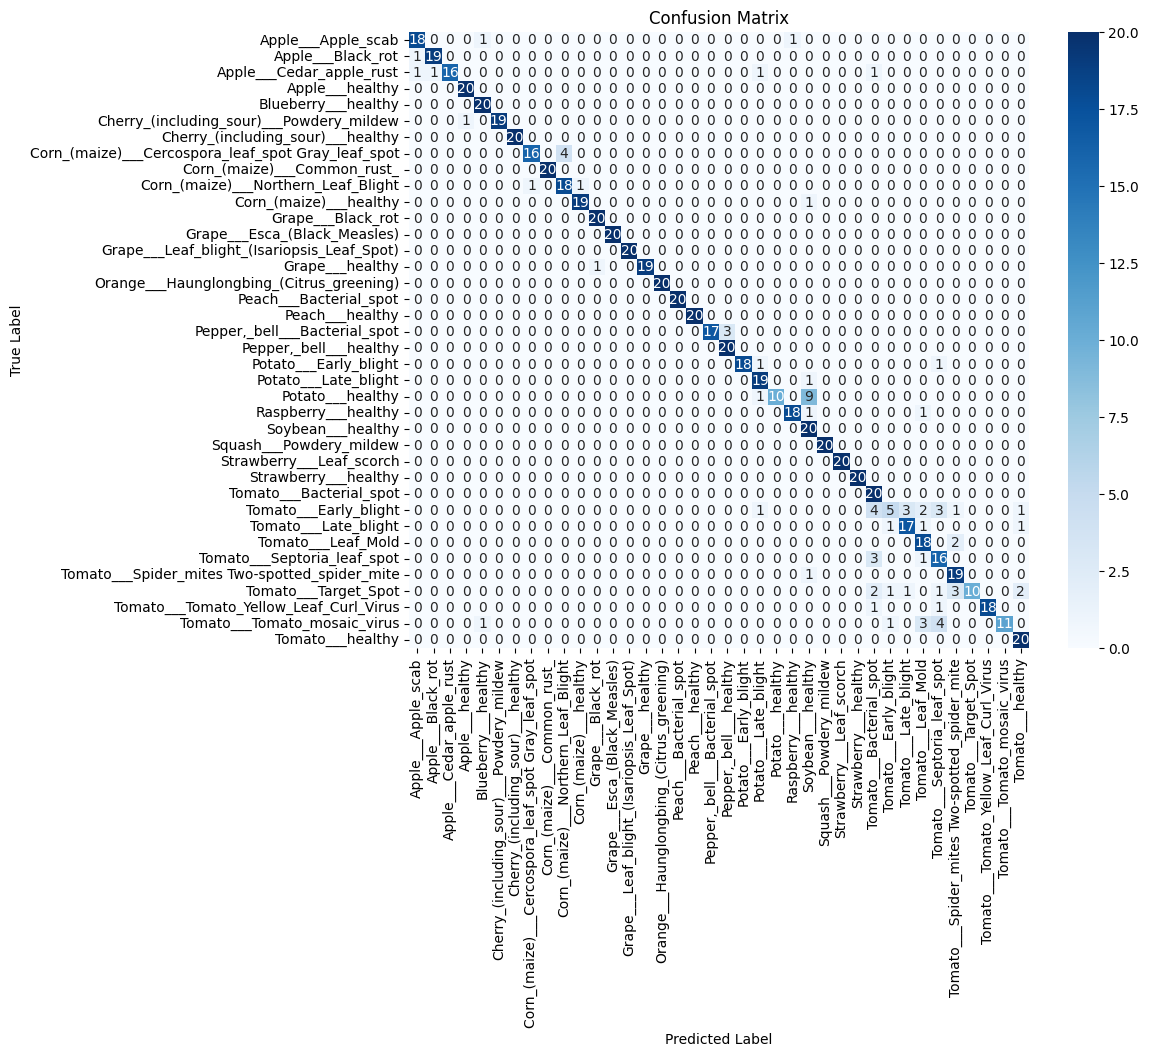

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.90      0.90      0.90        20
                                 Apple___Black_rot       0.95      0.95      0.95        20
                          Apple___Cedar_apple_rust       1.00      0.80      0.89        20
                                   Apple___healthy       0.95      1.00      0.98        20
                               Blueberry___healthy       0.91      1.00      0.95        20
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.97        20
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.80      0.86        20
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        20
               Corn_(maize)___Northern_Leaf_Blight      

In [19]:
# test model 

test_dir = "test_dataset"

# test dataset settings
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# load best model 
model = tf.keras.models.load_model('plant_disease.h5')

# evaluate model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# performance predictions
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

confusion_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))